In [7]:
import numpy as np
#Set the `numpy` pseudo-random generator at a fixed value
#This helps with repeatable results everytime you run the code. 
np.random.seed(1000)

import matplotlib.pyplot as plt
import os
import cv2
from skimage.transform import resize  
from keras.utils import normalize
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte
from skimage.exposure import equalize_adapthist
import tensorflow as tf
import platform
import logging
logging.getLogger('tensorflow').disabled = True


#Iterate through all images in Parasitized folder, resize to 64 x 64
#Then save as numpy array with name 'dataset'
#Set the label to this as 0


def check_gpu():

    if 'linux' in platform.platform().lower():
        print("Check GPU...")
        if len(tf.config.list_physical_devices('GPU')) == 0:
            print("GPU is not available!")
            quit()

        print("GPU is available!")

check_gpu()

image_directory = "/home/abidhasan/Documents/Indicate_FH/data/"
figpath = '/home/abidhasan/Documents/Indicate_FH/performance_figures'
modelpath = '/home/abidhasan/Documents/Indicate_FH/saved_model'

epochs = 100
batch_size = 32
SIZE = 256
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.




not_effected = os.listdir(image_directory + 'not_effected/')
for i, image_name in enumerate(not_effected):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'not_effected/' + image_name) # Reading all the images using opencv as BGR format. 
        if (image is None):  # Checking is any image is an None type object or Not. If it is, then next imge is continued.
                continue
        # converting BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = equalize_adapthist(image, kernel_size=None, clip_limit=0.1, nbins=256) # Applying the CLAHE to increase the contrast of the image
        image = img_as_ubyte(resize(image, (SIZE, SIZE), anti_aliasing=True)) 
        # Resizing the Image into size * size 
        # Converting an image to unsigned byte format, with values in [0, 255].
        dataset.append(np.array(image))
        label.append(0)

        
#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

effected = os.listdir(image_directory + 'effected/')
for i, image_name in enumerate(effected):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'effected/' + image_name)
        if (image is None):  # Checking is any image is an None type object or Not. If it is, then next imge is continued.
                continue
        # converting BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = equalize_adapthist(image, kernel_size=None, clip_limit=0.1, nbins=256) # Applying the CLAHE to increase the contrast of the image
        image = img_as_ubyte(resize(image, (SIZE, SIZE), anti_aliasing=True))
        # Resizing the Image into 256 * 256 
        # Converting an image to unsigned byte format, with values in [0, 255].
        dataset.append(np.array(image))
        label.append(1)


dataset = np.array(dataset)
print('Shape of dataset', dataset.shape)
label = np.array(label)

print('Shape of the labels', label.shape)

print('Count of the labels', np.unique(label, return_counts=True))

    
###############################################################    
    
 ### Split the dataset

# split the dataset into training and testing dataset.
# 1. Training data: 80%
# 2. Testing data: 20%

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

#Without scaling (normalize) the training may not converge. 
#Normalization is a rescaling of the data from the original range 
#so that all values are within the range of 0 and 1.

X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


Check GPU...
GPU is available!
Shape of dataset (8091, 256, 256, 3)
Shape of the labels (8091,)
Count of the labels (array([0, 1]), array([7203,  888]))


: 

In [5]:
#Apply CNN
# ### Build the model
from models import VGG3
#############################################################
###2 conv and pool layers. with some normalization and drops in between.
from models import my_model
INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)
dropout_rt = 0.4
filter_size = 32
#model = my_model(filter_size, INPUT_SHAPE, dropout_rt)
model = VGG3(INPUT_SHAPE, dropout_rt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 conv2d_6 (Conv2D)           (None, 320, 320, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 320, 320, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 160, 160, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 160, 160, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 160, 160, 64)      18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 160, 160, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 80, 80, 64)       0         
 2D)                                                             
          

In [6]:
history = model.fit(X_train, 
                         y_train, 
                         batch_size = batch_size, 
                         verbose = 1, 
                         epochs = epochs,      
                         validation_data=(X_test,y_test),
                         shuffle = False
                     )


model.save(modelpath+'/VGG3_WITHOUT_AUG.h5')  



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")



ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()

plt.savefig(figpath+'/VGG3_TRAIN_VS_VALIDATION_LOSS_WITHOUT_AUG.png', bbox_inches='tight')


2023-10-01 02:00:51.615710: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.41GiB (rounded to 7952793600)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-10-01 02:00:51.615750: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-10-01 02:00:51.615759: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 55, Chunks in use: 55. 13.8KiB allocated for chunks. 13.8KiB in use in bin. 3.2KiB client-requested in use in bin.
2023-10-01 02:00:51.615764: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 16, Chunks in use: 16. 8.2KiB allocated for chunks. 8.2KiB in use in bin. 8.0KiB client-requested in use in bin.
2023-10-01 02:00:51.615767: I tensorflow/tsl/framewor

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

1/1 [==============================] - 0s 77ms/step
The prediction for this image is:  [[0.63415116]]
The actual label for this image is:  1


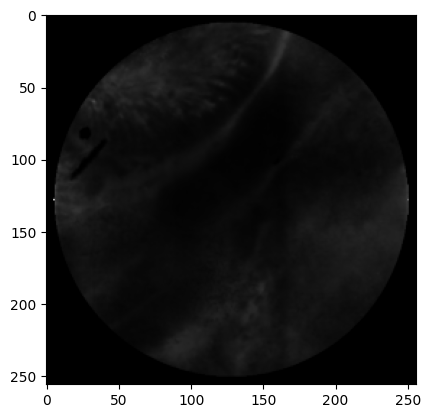

In [7]:
#########################################################################################
#Test the model on one image (for 300 epochs)
#img 23 is parasitized - correctly predicts near 0 probability
#Img 22, parasitized, correctly lables (low value) but relatively high value.
#img 24 is uninfected, correctly predicts as uninfected
#img 26 is parasitized but incorrectly gives high value for prediction, uninfected.

n=24  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_test[n])

In [8]:


#Instead f checking for each image, we can evaluate the model on all test data
#for accuracy
################################################################

#We can load the trained model, so we don't have to train again for 300 epochs!
from keras.models import load_model
# load model
model = load_model(modelpath+'/2DCNN_BASE_WITHOUT_AUG.h5')

#For 300 epochs, giving 82.5% accuracy

_, acc = model.evaluate(X_test, y_test)
print("Test accuracy = ", (acc * 100.0), "%")

51/51 [==============================] - 0s 6ms/step - loss: 0.5418 - accuracy: 0.8511
Test accuracy =  85.11427044868469 %


51/51 [==============================] - 0s 5ms/step


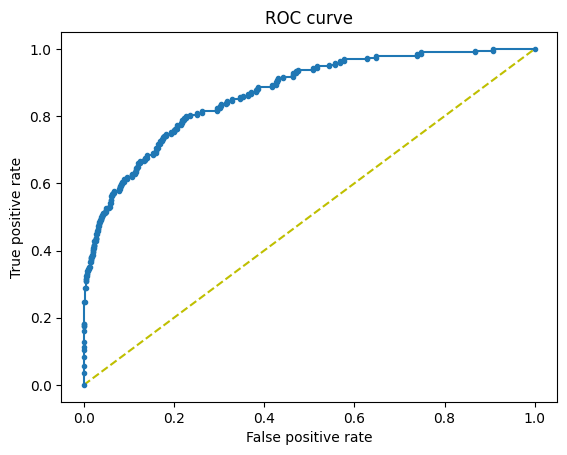

In [9]:
#How do we know how it is doing for parasitized vs uninfected? 
################################################################

#Confusion matrix
#We compare labels and plot them based on correct or wrong predictions.
#Since sigmoid outputs probabilities we need to apply threshold to convert to label.


#Check the confusion matrix for various thresholds. Which one is good?
#Need to balance positive, negative, false positive and false negative. 
#ROC can help identify the right threshold.
##################################################################
"""
Receiver Operating Characteristic (ROC) Curve is a plot that helps us 
visualize the performance of a binary classifier when the threshold is varied. 
"""
#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig(figpath+'/VGG3_ROC_CURVE_WITH_AUG.png', bbox_inches='tight')
plt.show()


In [10]:
"""
#One way to find the best threshold once we calculate the true positive 
and false positive rates is ...
The optimal cut off point would be where “true positive rate” is high 
and the “false positive rate” is low. 
Based on this logic let us find the threshold where tpr-(1-fpr) is zero (or close to 0)
"""
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

#Now use this threshold value in the confusion matrix to visualize the balance
#between tp, fp, fp, and fn


Ideal threshold is:  164    0.10352
Name: thresholds, dtype: float32


In [11]:
#AUC
#Area under the curve (AUC) for ROC plot can be used to understand hpw well a classifier 
#is performing. 
#% chance that the model can distinguish between positive and negative classes.

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.8669596672092603


51/51 [==============================] - 0s 5ms/step
Confusion Matrix
 [[1169  256]
 [  50  144]]
Average F1 Score per class: [0.88426626 0.48484848]
Average_Macro F1 Score of the Model: 0.6845573740430019
Average_Weighted F1 score of the Model: 0.8364052076430329
Test Accuracy of the Model: 85.11427044868469%


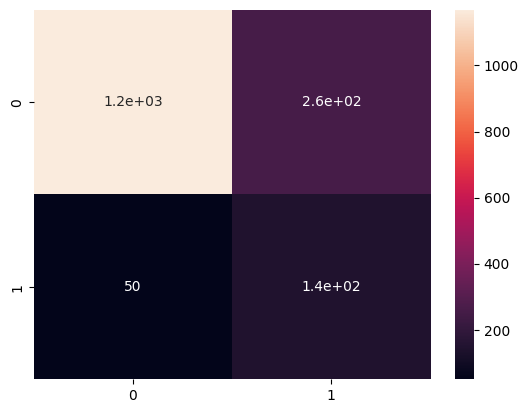

In [34]:
#########################################
mythreshold = 0.10352
y_preds= (model.predict(X_test)>= mythreshold).astype(int)
from sklearn.metrics import confusion_matrix, f1_score, classification_report

cm = confusion_matrix(y_test, y_preds)
print('Confusion Matrix\n', cm)
import seaborn as sns
hmp = sns.heatmap(cm, annot=True)
hmp_fig = hmp.get_figure()
hmp_fig.savefig(figpath+'/VGG3_heatmap_WITHOUT_AUG.png', dpi = 400)


f1scores_per_class = (f1_score(y_test, y_preds, average=None))
average_fscore_macro = (f1_score(y_test, y_preds, average="macro"))
average_fscore_weighted = (f1_score(y_test, y_preds, average="weighted"))
print('Average F1 Score per class:', f1scores_per_class)
print('Average_Macro F1 Score of the Model:', average_fscore_macro)
print('Average_Weighted F1 score of the Model:', average_fscore_weighted)
print(f'Test Accuracy of the Model: {acc * 100}%')

1/1 [==============================] - 0s 9ms/step


The prediction for this image is:  [[1]]
The actual label for this image is:  0  [1 = EFFECTED & 0= NOT EFFECTED]


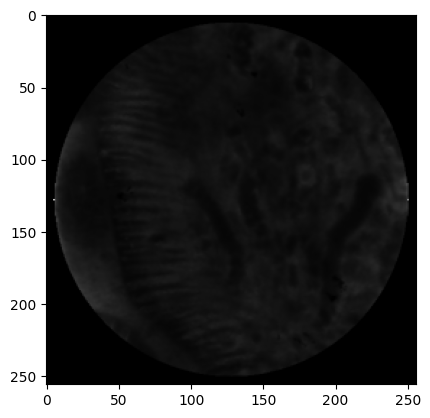

In [39]:
n=47   #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", (model.predict(input_img)>=mythreshold).astype(int))
print("The actual label for this image is: ", y_test[n] ," [1 = EFFECTED & 0= NOT EFFECTED]")